In [288]:
from numpy import genfromtxt
from sympy.utilities.iterables import multiset_permutations
from _fcm import cmeans
from _pfcm import pfcm
import re
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import csv
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import itertools
import imageio
import PIL
from PIL import Image
from turtle import *
from math import *
import math

In [32]:
#########################################################################################
############# Geodatensatz mit vielen Punkten, aber wenigen Dimensionen #################
#############         http://download.geonames.org/export/zip/          #################
#########################################################################################

text_file = open("allCountries.txt", "r", encoding="utf8")
ac_lines = text_file.read().split('\n')
text_file.close()
geonames = np.empty([np.size(ac_lines)-1,np.size(ac_lines[0].split('\t'))],dtype=object)
for i in range(0,np.size(ac_lines)-1):
    geonames[i] = ac_lines[i].split('\t')
geonames.shape

(1264940, 12)

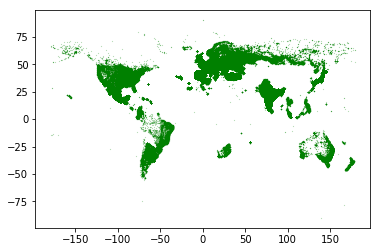

In [28]:
#Zeige alle Datenpunkte an
worldplot = plt.plot(geonames[0:,10].astype(float), geonames[0:,9].astype(float), 'g.')
plt.setp(worldplot, markersize=0.2)
plt.show()

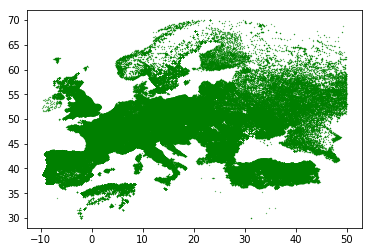

In [11]:
#Ausschnitt betrachten:
breitengrad = geonames[0:,9].astype(float)
laengengrad = geonames[0:,10].astype(float)
condition = [(breitengrad>30) & (breitengrad <70) 
             & (laengengrad>-10) & (laengengrad <50)]
cond_a = np.extract(condition, breitengrad)
cond_b = np.extract(condition, laengengrad)
euplot = plt.plot(cond_b,cond_a, 'g.')
plt.setp(euplot, markersize=0.5)
plt.show()

In [252]:
#########################################################################################
#############             Hochdimensionaler Geodatensatz                  ###############
#############   https://www.kaggle.com/reubencpereira/spatial-data-repo   ###############
#########################################################################################

In [7]:
def isFloatable(value):
    """
    Überprüft, ob ein gegebener Wert in Typ "float" gewandelt werden kann.
    value: zu überprüfender Wert
    """
    try:
        float(value)
        return True
    except ValueError:
        return False


In [253]:
def readKivaDataset():
    """
    Spatial Data Repository auslesen und vorbereiten für Plots. 
    Gibt außerdem aus, welche Daten in welcher Spalte stehen.
    kivaArray: gefilterter Datensatz
    """
    text_file = open("kivaData_augmented.txt", "r", encoding="utf8")
    lines = text_file.read().split('\n')
    text_file.close()
    kivaList = []
    for l in  csv.reader(lines, quotechar='"', delimiter=',',
                         quoting=csv.QUOTE_ALL, skipinitialspace=True):
        if(len(l)>2):
            #Filter für nicht vorhandene Werte!
            if(#isFloatable((l[2]) 
               #& isFloatable((l[3])
                 isFloatable((l[26])) #Niederschlag
               & isFloatable((l[29])) #Landnutzungsklassifikator
               & isFloatable((l[31])) #Temperatur
              # & isFloatable((l[30]) #Höhenwerte
              # & isFloatable((l[27]) #Reisezeit bis zur nächsten Großstadt in Stunden
              # & isFloatable((l[28]) #Durchschnittl. nächtliche Beleuchtungszeit (Reflektionsgrade 1-63)
              # & isFloatable((l[25]) #Populationsdichte (Bewohner pro Quadratkilometer)
                                ): 
                kivaList.append(l)
            elif(l[0]=="region"):
                kivaList.append(l)
    #In numpy-Array umwandeln und die Legende entfernen (geht nur so, da sonst Speicherfehler)
    kivaArray = np.empty([len(kivaList)-1,len(kivaList[0])],dtype=object)
    for l in range(1,len(kivaList)):
            kivaArray [l-1] = kivaList [l]
    #Index Legende:
    for i in range(0,43):
        print("Index "+str(i)+": "+str(kivaList[0][i]))
    return kivaArray

In [254]:
kivaArray = readKivaDataset()

Index 0: region
Index 1: country
Index 2: latitude
Index 3: longitude
Index 4: id
Index 5: funded_amount
Index 6: loan_amount
Index 7: activity
Index 8: sector
Index 9: use
Index 10: country_code
Index 11: currency
Index 12: partner_id
Index 13: posted_time
Index 14: disbursed_time
Index 15: funded_time
Index 16: term_in_months
Index 17: lender_count
Index 18: tags
Index 19: borrower_genders
Index 20: repayment_interval
Index 21: date
Index 22: location_type
Index 23: latlngImputed
Index 24: useforspatial
Index 25: popDensity
Index 26: precipitation
Index 27: TimeToCity
Index 28: AvgNightLight
Index 29: LandClassification
Index 30: Elevation
Index 31: Temperature
Index 32: Evaporation
Index 33: Modis_LAI
Index 34: Modis_EVI
Index 35: soil_orgc
Index 36: soil_phaq
Index 37: soil_clay
Index 38: soil_silt
Index 39: soil_sand
Index 40: Conflicts_total
Index 41: Conflicts_totalDeaths
Index 42: Conflicts_totalDeathsCivilians


In [ ]:
####################################################################
######################## Fuzzy C-Means ############################
####################################################################

In [250]:
niederschlag = kivaArray[:,26][0::50].astype(float) #Entsprechende Spalten auswählen und casten.
landnutzung = kivaArray[:,29][0::50].astype(float)
temperatur = kivaArray[:,31][0::50].astype(float)
fcm_kivaArray = np.vstack((niederschlag, temperatur, landnutzung)) #In Datenmatrix umwandeln für cmeans
[kiva_cntr_fcm,kiva_u_fcm,_,_,_,_,_] = cmeans(fcm_kivaArray, c=20, m=2, 
                                              error=0.001, maxiter=100) #FCM ausführen

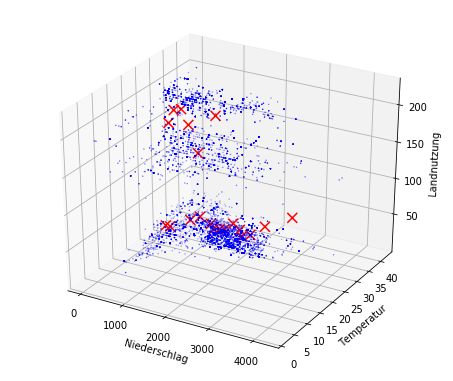

In [201]:
#Ergebnisse plotten!
fcm_fig = plt.figure(figsize=(6,5)) 
fcm_ax = Axes3D(fcm_fig)

fcm_ax.scatter(kiva_cntr_fcm.T[0], 
           kiva_cntr_fcm.T[1], 
           kiva_cntr_fcm.T[2], alpha = 1, s=100,c='r', marker='x',zorder=10)
fcm_ax.scatter(niederschlag, temperatur, landnutzung,s=0.5,c='b',marker='.',zorder=-1)

fcm_ax.set_xlabel('Niederschlag')
fcm_ax.set_ylabel('Temperatur')
fcm_ax.set_zlabel('Landnutzung')

plt.show()

#Scheinbar zeigt FCM in diesem sehr unscharfen Fall erst bei hoher 
#Clusteranzahl korrekte Gruppierungstendenzen an.
#Leider werden die oberen beiden Cluster immer zusammengefasst

In [ ]:
################################################################################
################################## PFCM ########################################
################################################################################

In [249]:
[kiva_cntr_pfcm,kiva_u_pfcm,_,_,_] = pfcm(data=fcm_kivaArray.T, c=20, m=2, eta=2, a=1, b=3, k=1,
                                          error_fcm=0.01, error_pfcm=0.001, maxiter_fcm=100, maxiter=100)

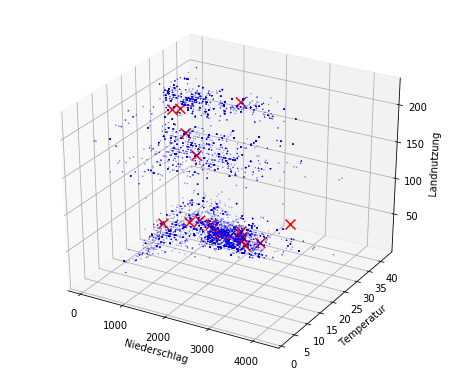

In [248]:
pfcm_fig = plt.figure(figsize=(6,5)) 
pfcm_ax = Axes3D(pfcm_fig)
pfcm_ax.scatter(kiva_cntr_pfcm[:,0], 
                kiva_cntr_pfcm[:,1], 
                kiva_cntr_pfcm[:,2], alpha = 1, s=100,c='r', marker='x',zorder=10)
pfcm_ax.scatter(niederschlag, temperatur, landnutzung,s=0.5,c='b',marker='.',zorder=-1)

pfcm_ax.set_xlabel('Niederschlag')
pfcm_ax.set_ylabel('Temperatur')
pfcm_ax.set_zlabel('Landnutzung')

plt.show()
#Clustererkennung von PFCM etwas besser bei kleinen Werten c~3,
#aber immer noch unzureichend genau
#Offensichtlich ist die Erkennung stark abhängig von den initialen Clusterprototypen
#In beiden Fällen wurden diese nicht angegeben.

In [257]:
#####################################################################
########################### NSFCDT ##################################
#####################################################################

In [256]:
class Triangle:
    """
    Modifizierte Delaunay-Dreieck-Datenstruktur
    visited soll speichern, ob das betrachtete Dreieck schon besucht wurde. 
    Mit diesem Attribut lässt sich in Erfahrung bringen, ob ein Nachbardreieck 
    im Clusteringprozess schon zugeorndet wurde oder nicht.
    """
    def __init__(self):
        self.id = -1
        self.points = []
        self.visited = False
        self.neighbors = []

In [258]:
def convertTriangles(points,tri):
    """
    Wandelt die Dreiecke der Delaunay Triangulation tri in modifizierte Datenstruktur um.
    points: Die betrachtete Punkte der Dreiecke
    tri: Delaunay-Triangulation 
    """
    convertedTriangles = []
    for i in range(0,len(tri.simplices)):
        newT = Triangle()
        newT.id = i
        newT.points = points[tri.simplices[i]] 
        newT.neighbors = finde_nachbardreiecke(i,tri)
        convertedTriangles.append(newT)
    return convertedTriangles

In [259]:
def finde_nachbardreiecke(dindex,tri): 
    """
    Diese Funktion findet alle Nachbarn eines Dreiecks und löscht die 
    Einträge nicht gefundener Nachbarn (z.B. wenn es weniger als 3 Nachbarn gibt)
    dindex: Der Index des betrachteten Dreiecks
    tri: Delaunay Triangulation
    nachbarn: Liste an Nachbardreiecken als Liste von Indizes dieser Dreiecke
    """
    nachbarn = tri.neighbors[dindex][tri.neighbors[dindex]>0]
    return nachbarn

In [260]:
def satisfiable(triangle,lower_limit,upper_limit,min_angle):    
    """
    Berechne, ob das Dreieck bzgl. der Grenzwerte die richtige Größe und Winkel hat
    triangle: Das betrachtete Dreieck
    lower_limit: Untergrenze für den Flächeninhalt des Dreiecks
    upper_limit: Obergrenze für den Flächeninhalt des Dreiecks
    min_angle: Der kleinste Winkel im Dreieck muss mindestens angle Grad haben
    """
    a = np.linalg.norm(triangle.points[0]-triangle.points[1])
    b = np.linalg.norm(triangle.points[0]-triangle.points[2])
    c = np.linalg.norm(triangle.points[1]-triangle.points[2])
    smallest_angle_found = -1
    if (a + b >= c) and (b + c >= a) and (c + a >= b):
        A = degrees(acos((b**2 + c**2 - a**2)/(2*b*c)))
        B = degrees(acos((c**2 + a**2 - b**2)/(2*c*a)))
        C = degrees(acos((a**2 + b**2 - c**2)/(2*a*b)))
        smallest_angle_found = np.min([A,B,C])
    else:
        return False    
    s = (a + b + c) / 2
    area = (s*(s-a)*(s-b)*(s-c)) ** 0.5
    if((area >= lower_limit) & (area <= upper_limit) & (smallest_angle_found > min_angle)):
        return True
    else:
        return False

In [261]:
def NSFCDT(points, lower_limit, upper_limit, min_angle): 
    """
    Originales NSFCDT ohne Unterscheidung der Cluster. Die Dreiecke können also nur in 
    einer Farbe dargestellt werden.
    points: Array mit Datenpunkten
    lower_limit: Untergrenze für den Flächeninhalt des Dreiecks
    upper_limit: Obergrenze für den Flächeninhalt des Dreiecks
    min_angle: Der kleinste Winkel im Dreieck muss mindestens angle Grad haben
    """       
    tri = Delaunay(points)
    DT = convertTriangles(points,tri)
    clusterSet = set()
    tmpSet = set()
    stack = []
    for dt in DT:
        if(dt.visited == False):
            newSet = set() 
            stack.append(dt)
            while(len(stack) > 0):
                t = stack.pop()
                if(satisfiable(t,lower_limit, upper_limit,min_angle) & (t.visited == False)):
                    t.visited = True
                    newSet = newSet.union({t}) 
                    tmpSet = t.neighbors
                    for el in tmpSet: #Es wird über die Indizes der Nachbardreiecke von t iteriert
                        if(DT[el].visited == False): # DT-Index entspricht der ID des jeweiligen Dreiecks
                            stack.append(DT[el])
            clusterSet = clusterSet.union(newSet)
    return tri,clusterSet

In [262]:
#Für Unterscheidung der Cluster und verschiedene Einfärbung
def NSFCDT2(points, lower_limit, upper_limit, min_angle): 
    """
    Modifiziertes NSFCDT mit Unterscheidung der Cluster. Die Dreiecke können also in 
    verschiedenen Farbe dargestellt werden.
    points: Array mit Datenpunkten
    lower_limit: Untergrenze für den Flächeninhalt des Dreiecks
    upper_limit: Obergrenze für den Flächeninhalt des Dreiecks
    min_angle: Der kleinste Winkel im Dreieck muss mindestens angle Grad haben
    """   
    tri = Delaunay(points)
    DT = convertTriangles(points,tri)
    clusterList = []
    tmpSet = set()
    stack = []
    for dt in DT:
        if(dt.visited == False):
            newList = list()
            stack.append(dt)
            while(len(stack) > 0):
                t = stack.pop()
                if(satisfiable(t,lower_limit, upper_limit,min_angle) & (t.visited == False)):
                    t.visited = True
                    newList.append(t) 
                    tmpSet = t.neighbors
                    for el in tmpSet: #Es wird über die Indizes der Nachbardreiecke von t iteriert
                        if(DT[el].visited == False): #DT-Index entspricht der ID des jeweiligen Dreiecks
                            stack.append(DT[el])
            if (len(newList)>0):
                clusterList.append(newList)
    return tri,clusterList

In [263]:
def findColorPoints(I,limR,limG,limB):
    """
    Finde alle Punkte in angegebenem Farbraum 
    I: Das betrachtete Bild als (n x 5)-Array, dabei ist die erste Spalte der 
    Zeilenindex des Pixels, die zweite Spalte enthält den Spaltenindex des Pixels,
    Spalten drei, vier und fünf enthalten die RGB-Werte des Pixels
    n: Anzahl der Pixel im Bild I
    limR: Bereich des roten Farbraumanteils, in dem sich der Pixel befinden darf
    limG: Bereich des grünen Farbraumanteils, in dem sich der Pixel befinden darf
    limB Bereich des blauen Farbraumanteils, in dem sich der Pixel befinden darf
    """
    found = []
    for el in I:
        if ((el[2] in limR)
           & (el[3] in limG)
           & (el[4] in limB)):
            found.append([el[0],el[1]])
    return np.array(found)

In [264]:
#Diese Variante ist deutlich langsamer, als findColorPoints
def findColorPoints2(I,limR,limG,limB): 
    found = []
    for idx in np.ndindex(I0.shape[0:2]):
            if ((I[idx][0] in limR) & (I[idx][1] in limG) & (I[idx][2] in limB)):
                found.append(list(idx))
    return np.array(found)

In [265]:
def reshapeImg(image):
    """
    Wandelt das (a x b x 3) Bildarray in ein (a*b x 5) Array um 
    """
    newI = []
    for a in range(0,image.shape[0]):
        for b in range(0,image.shape[1]):
            newI.append(np.concatenate([[a,b],image[a,b]]))
    return np.array(newI)

In [266]:
#Teste NSFCDT mit selbsterstelltem Datensatz
xe = np.concatenate(tuple([[x for x in range(0,4)] for y in range(0,4)]))
ye = np.concatenate(tuple([[y for x in range(0,4)] for y in range(0,4)]))
xe = np.concatenate((xe,[1.1,1.2,1.3,0.9,0.8,1.2,1.3,0.9],
                        [3.1,3.2,3.3,2.9,2.8,3.2,3.3,2.9,2.8],
                        [0,0.1,0.15,0.2,0.05,0.3,0.25,0.17,0.22,0.6,0.5]))
ye = np.concatenate((ye,[1,1.1,1.1,1.2,0.8,0.9,0.95,1],
                        [3,2.95,2.9,2.8,3.2,3.1,3.1,3,2.9],
                        [2.6,2.9,3,2.2,2.85,2.91,2.44,2.89,2.77,2.5,2.7]))
                     
testPoints = np.array([xe,ye]).T
[triangulation0,clusters0] = NSFCDT2(testPoints,0,0.05,10)
print("Der Datensatz hat "+str(len(clusters0))+" Cluster.")
print("Es existieren "+str(len(triangulation0.simplices))+" Dreiecke in der Triangulation.")

Der Datensatz hat 3 Cluster.
Es existieren 75 Dreiecke in der Triangulation.


In [267]:
def getColor(nat):
    """
    Gibt für alle natürlichen Zahlen (int) einen Farbwert zurück
    nat: natürliche Zahl
    """
    colormap =  ['g','b','r','c','#C0FF20','#FFB720','#852FFF','y','m']
    return colormap[np.mod(nat,9)]


In [268]:
def plotTriangles(triangulation,clusters,printImage,printDots,linewidth,figuresize):
    """
    Routine zum Plotten von Datensätzen mit geclusterter Triangulation
    triangulation: Delaunay Triangulation
    clusters: Liste von Listen mit Dreiecken, jede äußere Liste kennzeichnet einen Cluster
    printImage: Soll ein Hintergrundbild geplottet werden? (True, wenn Bild geclustert) 
    printDots: Sollen die Datenpunkte ebenfalls eingezeichnet werden?
    linewidth: Dicke der Dreieckskanten
    figuresize: Maße des Plots als Integer-Tupel
    """
    fig = plt.subplots(figsize = figuresize)
    xcord = triangulation.points.T[0]
    ycord = triangulation.points.T[1]
    if(printDots):
        plt.plot(xcord,ycord,'ko',zorder = 1)
    if(printImage==True):
        img = imageio.imread("mars1.jpg") #Hintergrundbild (z.B. zu clusterndes Satellitenbild)
        plt.imshow(img,zorder=0,extent=[0,I0.shape[1],I0.shape[0],0])
        for i in range(0,len(clusters)):
            simplices = np.array([triangulation.simplices[x.id] for x in clusters[i]])
            plt.triplot(ycord,xcord,simplices,linestyle ='-',color = getColor(i),lw=linewidth)
    else:
        for i in range(0,len(clusters)):
            simplices = np.array([triangulation.simplices[x.id] for x in clusters[i]])
            plt.triplot(xcord,ycord,simplices,linestyle ='-',color = getColor(i),lw=linewidth)
    plt.show()

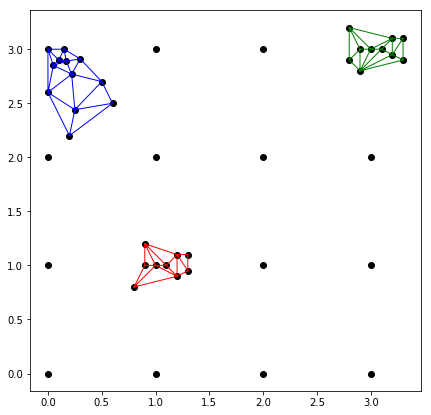

In [269]:
plotTriangles(triangulation0,clusters0,False,True,1,(7,7))

In [270]:
I0 = np.asarray(PIL.Image.open('mars2.jpg')) #Gesampeltes Bild, aus Performancegründen.
I1 = reshapeImg(I0)
foundInRange = findColorPoints(I1,range(30,70),range(30,70),range(40,70))
print("Es wurden im angegebenen Farbraum "+str(foundInRange.shape[0])+" Punkte gefunden.")

Es wurden im angegebenen Farbraum 25396 Punkte gefunden.


In [271]:
[triangulation1,clusters1] = NSFCDT2(foundInRange,0,10,1)
print("Der Datensatz hat "+str(len(clusters1))+" Cluster.")
print("Es existieren "+str(len(triangulation1.simplices))+" Dreiecke in der Triangulation.")

Der Datensatz hat 22 Cluster.
Es existieren 50762 Dreiecke in der Triangulation.


In [272]:
#Entferne alle zu kleinen Cluster:
clusters1 = np.extract(np.array([len(x)>100 for x in clusters1]),clusters1)

In [273]:
#Wieviele Dreiecke haben die Cluster jeweils?
for el_index in range(0,len(clusters1)):
    print("Cluster "+str(el_index)+" hat "+str(len(clusters1[el_index]))+" Dreiecke.")

Cluster 0 hat 48544 Dreiecke.
Cluster 1 hat 389 Dreiecke.
Cluster 2 hat 566 Dreiecke.


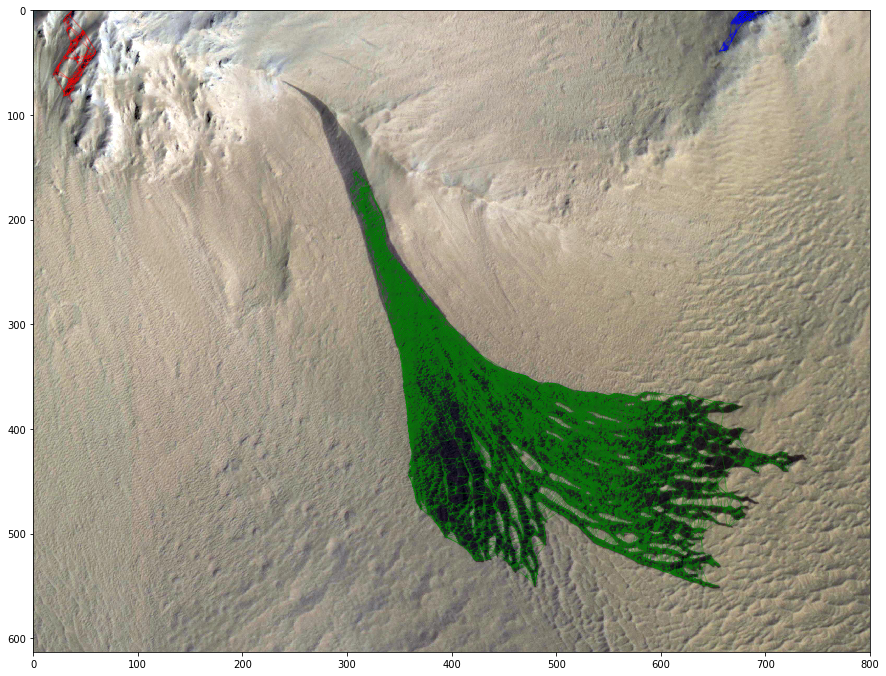

In [274]:
#EXTREM SCHWIERIG ZU CLUSTERNDES BILD!
plotTriangles(triangulation1,clusters1,True,False,0.2,(15,15))

In [276]:
######################################################################
################### Cluster Validity Indices #########################
######################################################################

In [277]:
def covariance(i,u,x,v,m):
    '''
        Hilfsfunktion für die Berechnung des FHV CVI
        Kovarianzmatrix für einen Cluster v_i
        i ist der betreffende Clusterindex
        d ist die Anzahl der Features
        n ist die Anzahl der Datenpunkte
        ci ist die zu berechnende Kovarianzmatrix mit Dimension dxd
        nenner ist der Nenner im Bruch für die Formel der Kovarianzmatrix
        zaehler ist der Zaehler im Bruch für die Formel der Kovarianzmatrix
        l und p sind Laufvariablen für die Features
    '''
    d = x.shape[1]
    n = x.shape[0]
    ci = np.zeros((d,d))     
    nenner = np.power(u[i],m).sum() #hängt nicht von p und l ab, bleibt also gleich
    
    for p in range(0, d):
        for l in range(0, d):
            zaehler = 0
            for k in range(0,n):
                zaehler = zaehler+((u[i,k]**m)*(x[k,p]-v[i,p])*(x[k,l]-v[i,l]))
            ci[p,l] = zaehler/nenner    
    return np.asmatrix(ci)

In [278]:
def getMinPermutation(cntr0, cntr1):
    """
        Diese Funktion bringt cntr1 in die richtige Reihenfolge, indem die 
        Permutation mit dem geringsten Abstand zu cntr0 gewählt wird
        cntr0: Initiale Clusterzentroiden in der richtigen Reihenfolge
        cntr1: Berechnete Clusterprototypen in ungewisser Reihenfolge
        minPerm: Initial kleinste Permutation von cntr1
        minDistance: Initial kleinste Distanz von cntr1 zu cntr0
        newDistance: Neu berechnete Distanz in jedem Schleifendurchlauf
        Auch anwendbar auf die Zugehörigkeitsmatrix u
    """
    minPerm = cntr1
    minDistance = np.absolute(cntr1-cntr0).sum()
    for p in multiset_permutations(cntr1.tolist()): 
        newDistance = np.absolute(p-cntr0).sum()
        if newDistance < minDistance:
            minPerm = p
            minDistance = newDistance
    return np.asmatrix(minPerm)


In [279]:
###########################################################
########   Normalised Partition Coefficient   #############
###########################################################
def npc (u):
    """
       Formel Kapitel 2 Seite 6
       u ist die Zugehoerigkeitsmatrix
       c ist die Anzahl der Cluster
       vpc ist die Formel auf Seite 5, Kapitel 2
    """
    c = u.shape[0]
    vpc = (np.power(u,2)).sum()/u.shape[1]
    vnpc = 1-((c/(c-1))*(1-vpc))
    return vnpc
       

In [280]:
###########################################################
#################   Fuzzy Hypervolume  ####################
###########################################################
def fhv(u,x,v,m):
    '''
        Fuzzy Hypervolume CVI
        c ist die Anzahl der Clusterzentren
        vfhv ist der initiale Wert für die Zielfunktion
    '''
    c = v.shape[0]
    vfhv = 0
    
    for i in range(0,c):
        vfhv += np.sqrt(np.linalg.det(covariance(i,u,x,v,m))) 
    
    return vfhv 

In [281]:
def c_analysis():
    """
        Berechnung der durchschnittlichen Zugehörigkeitsmatrizen und Clusterprototypen
        über fcm_times_upper Durchläufe für c = 2..max_cluster. 
        Anschließende Berechnung der CVIs (NPC,FHV) mithilfe der o.g. 
        Durchschnittsmatrizen und Ermittlung der optimalen Clusteranzahl c_opt.
        data: Datensatz
        npc_arr: Array mit allen NPC-Werten aus Schleifendurchläufen i
        fhv_arr: Array mit allen FHV-Werten aus Schleifendurchläufen i
        cntr_avrg: Durchschnittlich berechnete Clusterprototypen
        u_avrg: Durchschnittlich berechnete Zugehörigkeitsmatrix
        cvi_npc: Berechneter NPC-Wert für aktuellen Schleifendurchlauf i
        cvi_fhv: Berechneter FHV-Wert für aktuellen Schleifendurchlauf i
        opt_c: Optimale Anzahl an Clusterzentren
    """
    data = np.vstack((kivaArray[:,26][0::100].astype(float),
                      kivaArray[:,29][0::100].astype(float),
                      kivaArray[:,31][0::100].astype(float))).T
    npc_arr = np.array([])
    fhv_arr = np.array([])
    fcm_times_upper = 3
    max_cluster = 9
    """
    Im Folgenden wird FCM für verschiedene Clusteranzahlen 
    jeweils fcm_times_upper-1 mal durchgeführt.
    In den Clusteringergebnissen werden alle Zentroide permutiert und die Daten
    derjenigen Permutation gefunden, welche bezüglich ihrer Zentroide und Zugehörigkeiten
    den kleinsten Abstand zu allen anderen Permutationen hat. Diese Partitionierung ist das 
    jeweils beste Ergebnis für die betrachtete Clusteranzahl i.
    """
    for i in range (2,max_cluster):
        cntr_avrg = np.zeros((i,3))
        u_avrg = np.zeros((i,data.shape[0]))
        [cntr_init,u_init,_,_,_,_,_] = cmeans(data.T, i, 2, 0.001, 50)
        for j in range(1,fcm_times_upper):
            [cntr,u,_,_,_,_,_] = cmeans(data.T, i, 2, 0.001, 50)
            cntr_avrg += getMinPermutation(cntr_init,cntr)
            u_avrg += getMinPermutation(u_init,u)
        cntr_avrg /= (fcm_times_upper-1)
        u_avrg /= (fcm_times_upper-1)
        cvi_npc = npc(u_avrg)
        cvi_fhv = fhv(u_avrg,data,cntr_avrg,2)
        npc_arr = np.append(npc_arr,cvi_npc)
        fhv_arr = np.append(fhv_arr,cvi_fhv)
        print("\nCVIs für "+str(i)+" Cluster:")
        print("NPC: "+str(cvi_npc))
        print("FHV: "+str(cvi_fhv))
        
        fig2 = plt.figure(figsize=(7,5)) 
        ax = Axes3D(fig2)
        ax.scatter(cntr_avrg.T[0],cntr_avrg.T[2],cntr_avrg.T[1], alpha = 1, s=100,c='r', marker='x',zorder=10)
        ax.scatter(data.T[0], data.T[2], data.T[1],s=0.1,c='b',marker='.',zorder=-1)
        plt.show()

    """
    Strategie zur Ermittlung der optimalen Clusteranzahl mithilfe der beiden CVIs:
    Ein optimaler Wert für NPC ist 1. Ein optimaler Wert für FHV ist 0.
    - Quetschen der FHV-Werte auf [0;1] (Normalisierung mit fhv_arr/max(fhv_arr))
    - argmax(NPC+(1-NORMALIZED(FHV))) ist der Index des besten Wertes
    """
    #opt_c = np.argmax(npc_arr+(1-fhv_arr/np.max(fhv_arr)))+2
    print("Nach FHV beträgt die optimale Clusteranzahl: "+str(np.argmax(fhv_arr)+2))
    print("Nach NPC beträgt die optimale Clusteranzahl: "+str(np.argmax(npc_arr)+2))
    #print("Die optimale Clusteranzahl für diese Daten ist: "+ str(opt_c))



CVIs für 2 Cluster:
NPC: 0.6892137243150493
FHV: 189118.17084191885


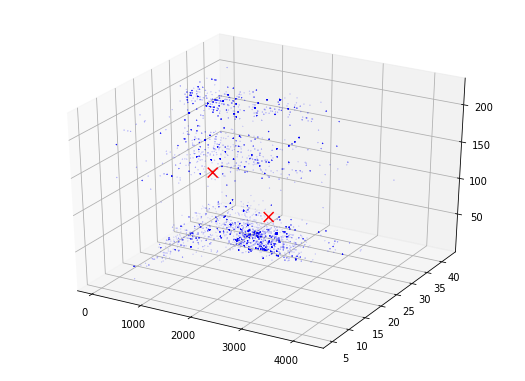


CVIs für 3 Cluster:
NPC: 0.6690599666063077
FHV: 194085.86018043265


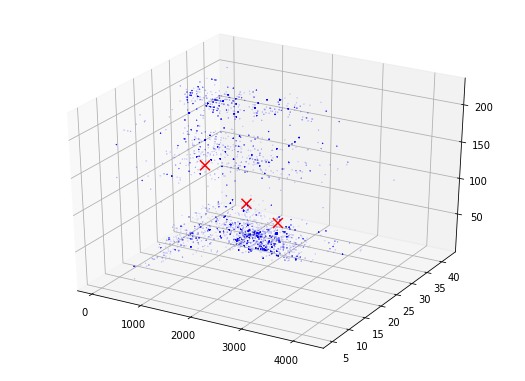


CVIs für 4 Cluster:
NPC: 0.6233598058707579
FHV: 209325.97372303638


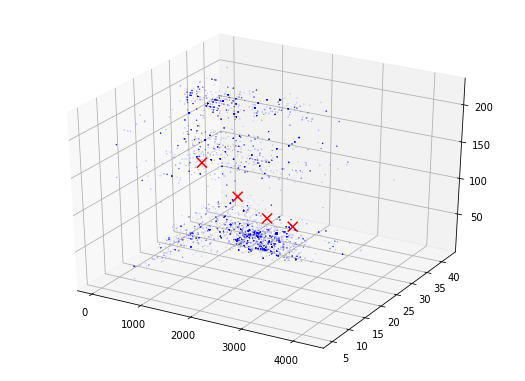


CVIs für 5 Cluster:
NPC: 0.6454078235298445
FHV: 216356.20196941023


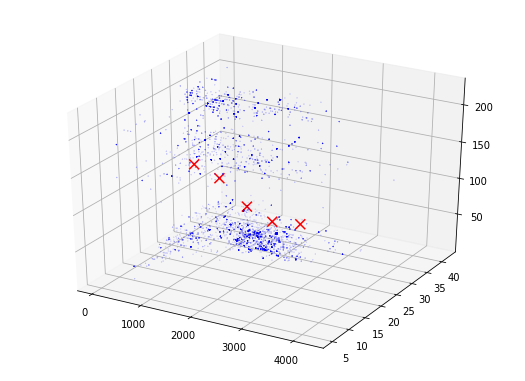


CVIs für 6 Cluster:
NPC: 0.6273163891742193
FHV: 215202.3309162608


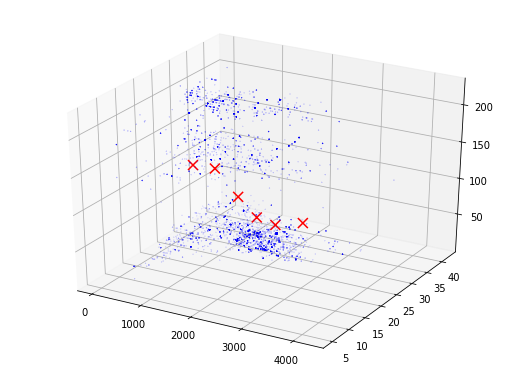


CVIs für 7 Cluster:
NPC: 0.5672227530867987
FHV: 222645.1873087769


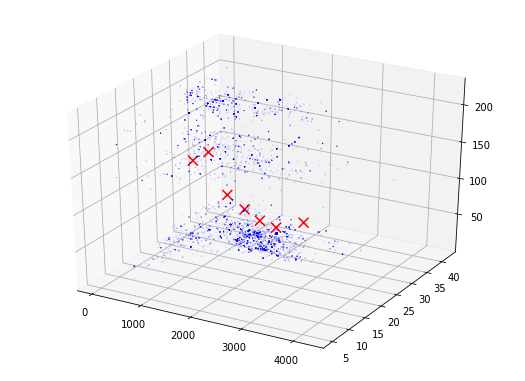


CVIs für 8 Cluster:
NPC: 0.5751140731165324
FHV: 213844.36724509852


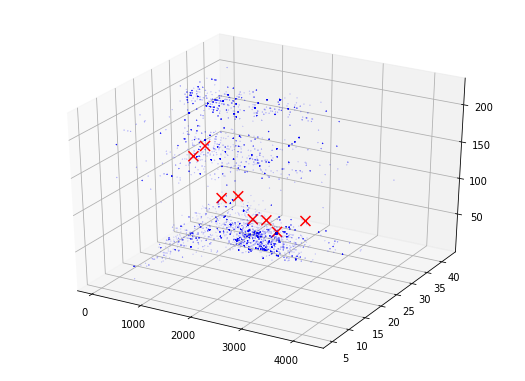

Nach FHV beträgt die optimale Clusteranzahl: 7
Nach NPC beträgt die optimale Clusteranzahl: 2


In [282]:
c_analysis()

In [283]:
###############################################################
################# VAT-Algorithmus #############################
###############################################################

In [284]:
def argmin(I,J,R):
    """
    Gibt die Indizes des kleinsten Elements in R bezüglich der Zeilen 
    und Spalten, die in den Mengen I und J angegeben sind, zurück
    """
    minimum = np.iinfo(np.int32).max
    for i in I:
        for j in J:
            #print("i: "+str(i)+" j: "+str(j))
            if(R[i,j] < minimum):
                minimum = R[i,j]
                [min_i,min_j] = [i,j]
    return min_i,min_j

In [285]:
def vat(data):
    """
    Stellt einen Datensatz als Graustufenbild so dar, dass sich Cluster entlang
    der Hauptdiagonalen als dunkle Quadrate ablesen lassen
    data: Array mit Datenpunkten
    """
    n = data.shape[0]
    R = cdist(data,data)
    R_grey = np.zeros(R.shape)
    I = set()
    J = set(range(0,n))
    P = np.zeros(n,dtype=np.int)
    [i,j] = argmin(J,J,R)
    P[0] = j
    I = I.union({j})
    J = J.difference({j})
    for t in range(1,n):
        [i,j] = argmin(I,J,R)
        P[t] = j
        I = I.union({j})
        J = J.difference({j})
    for x in range(0,n):
        for y in range(0,n):   
            #print("x: "+str(x)+" y: "+str(y))
            R_grey[x,y] = R[P[x],P[y]]
    I_grey = (R_grey/np.max(R_grey)*255).astype(dtype=np.uint8)
    return Image.fromarray(I_grey, 'L')   

In [294]:
vat_data = np.vstack((kivaArray[:,26][0::500].astype(float),
                      kivaArray[:,29][0::500].astype(float),
                      kivaArray[:,31][0::500].astype(float))).T

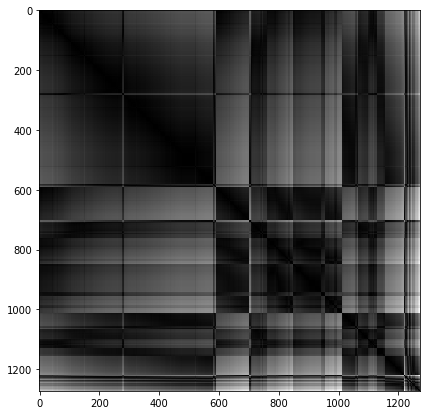

In [295]:
vatfig,vatax = plt.subplots(figsize=(7,7))
vatax.imshow(vat(vat_data),cmap='gray')
#Es sind 3 große und viele kleine Subcluster zu erkennen

In [87]:
############################################
######### Subset-Similarity Index ##########
############################################

In [89]:
def ssi(P,Q):
    """
        Subset Similarity Index (Standardnorm) für den
        Vergleich zweier Partitionierungen P und Q
        k ist die Anzahl der Cluster in P
        l ist die Anzahl der Cluster in Q
        s ist die Ähnlichkeitsmatrix bzgl der beiden Cluster P und Q
        S ist das Endergebnis
    """
    k = P.shape[1]
    l = Q.shape[1]
    s = np.zeros((k,l))

    for i in range(0,k):
        for j in range(0,l):
            s[i,j] = np.minimum(P[:,i],Q[:,j]).sum()/np.maximum(P[:,i],Q[:,j]).sum()
    S = max(min(np.amax(s, axis=0)),min(np.amax(s, axis=1)))
    return S

def ssi_dist(P,Q):
    return 1-ssi(P,Q)

In [296]:
#ssi(kiva_u_fcm, kiva_u_pfcm)

In [ ]:
############################################
####### Partitionierungsstabilität #########
############################################

In [ ]:
def part_stability(data,name):
    """
        Berechnet die optimale Clusteranzahl copt
        data ist der zu partitionierende Datensatz
        name ist der Name des Datensatzes 
        n ist die Anzahl der Datenpunkte im Datensatz
        m ist die Anzahl der Partitonierungen pro Clusteranzahl
        cmin ist die minimale Clusteranzahl für Zerlegungen
        cmax ist die maximale Anzahl für Zerlegungen
        perm sind die Indizes einer zweidimensionalen oberen Dreiecksmatrix 
             mit Dimension mxm (ohne Hauptdiagonale!) als Vektoren
        U siehe getPartitions()
        S1 Liste mit Partitionierungsstabilitäten für alle Clusteranzahlen für Subset Similarity Index
        S2 Liste mit Partitionierungsstabilitäten für alle Clusteranzahlen für Hüllermeier-Rifqi Index
    """
    [n,m,cmin,cmax] = [data.shape[0],30,2,11]
    perm = getPerm(m)
    U = getPartitions(data,cmin,cmax,m)
    S1 = np.empty((cmax-cmin+1))
    S2 = np.empty((cmax-cmin+1))

    for c in range(cmin,cmax+1):
        #print("Clusteranzahl: "+str(c))
        sc1 = 0
        sc2 = 0
        for p in perm:
            #print("Datenpaar: "+str(p))
            sc1 += ssi_dist(shapeDown(U[c-cmin,p[0]],c,n).T,shapeDown(U[c-cmin,p[1]],c,n).T)
            sc2 += hri_dist(shapeDown(U[c-cmin,p[0]],c,n).T,shapeDown(U[c-cmin,p[1]],c,n).T)
        sc1 /= (m*(m-1)/2)
        sc2 /= (m*(m-1)/2)
        S1[c-cmin] = sc1
        S2[c-cmin] = sc2
    print("Ergebnis für den "+name+"-Datensatz:\n")
    print("s(c) für Subset-Similarity-Index:\n"+str(S1)+"\nOptimum: "+str(np.argmin(S1)+cmin)+" Cluster")
    print("s(c) für Hüllermeier-Rifqi-Index:\n"+str(S2)+"\nOptimum: "+str(np.argmin(S2)+cmin)+" Cluster")
